In [1]:
import os
import numpy as np 
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold, ShuffleSplit, GridSearchCV

In [2]:
cwd = os.getcwd()
df = pd.read_csv(cwd+'/datasets/Bengaluru_House_Data.csv')
print(df.shape)
df.head()

(13320, 9)


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.000,1.000,39.070
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.000,3.000,120.000
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.000,3.000,62.000
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.000,1.000,95.000
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.000,1.000,51.000


# Data Prep - feature extraction, missing values removal, feature engineering, outlier detection

In [3]:
# removed certain columns for simplicity 
df.drop(['area_type', 'society', 'balcony', 'availability'], axis=1, inplace=True)
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.000,39.070
1,Chikka Tirupathi,4 Bedroom,2600,5.000,120.000
2,Uttarahalli,3 BHK,1440,2.000,62.000
3,Lingadheeranahalli,3 BHK,1521,3.000,95.000
4,Kothanur,2 BHK,1200,2.000,51.000


In [4]:
#checking for null values - number of rows where each of the column value is null
df.isnull().sum()

# since lot of rows have null values, removed them for simplicity 
df.dropna(inplace=True)
df.isnull().sum()
df.shape

(13246, 5)


### Column - Size

In [5]:
# checking the size column since it looks like there are multiple kinds of values in there
# checing all the unique values in that column 
print(df['size'].unique())
df['bhk'] = df['size'].apply(lambda x : x.split(' ')[0]).astype('int')
df.drop('size', axis=1, inplace=True, errors = 'ignore')
df.head(3)

['2 BHK' '4 Bedroom' '3 BHK' '4 BHK' '6 Bedroom' '3 Bedroom' '1 BHK'
 '1 RK' '1 Bedroom' '8 Bedroom' '2 Bedroom' '7 Bedroom' '5 BHK' '7 BHK'
 '6 BHK' '5 Bedroom' '11 BHK' '9 BHK' '9 Bedroom' '27 BHK' '10 Bedroom'
 '11 Bedroom' '10 BHK' '19 BHK' '16 BHK' '43 Bedroom' '14 BHK' '8 BHK'
 '12 Bedroom' '13 BHK' '18 Bedroom']


,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.000,39.070,2
1,Chikka Tirupathi,2600,5.000,120.000,4
2,Uttarahalli,1440,2.000,62.000,3


In [6]:
# since there are multiple values, and we only need the numerical part for the analysis, so we filter that out 
print(df['bhk'].unique()) # this shows some outlier so investigate further
df[df['bhk']>20] # the 4684 index is certainly an outlier based on total_sqft, but keeping it for now

[ 2  4  3  6  1  8  7  5 11  9 27 10 19 16 43 14 12 13 18]


,location,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,8000,27.000,230.000,27
4684,Munnekollal,2400,40.000,660.000,43


### Column -  total_sqft

In [7]:
# checking the total_sqft column since it looks like there are multiple kinds of values in there
# checing all the unique values in that column 
df['total_sqft'].unique() #there are some values which contain '-', we can filter those out 

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [8]:
# will try to convert the col into float side by side to removing those '-' values
def isfloat(x):
    try:
        float(x)
    except:
        return False
    return True

# using negate operator to print out all the '-' rows
df[~df['total_sqft'].apply(isfloat)].head(15)

# now there are some values have '34.46Sq. Meter', '1100Sq. Yards' and other uniformities, since these ones are diff units, we will just ignore them, for 
# the '-' ones will take avg

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.000,186.000,4
122,Hebbal,3067 - 8156,4.000,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.000,54.005,2
165,Sarjapur,1145 - 1340,2.000,43.490,2
188,KR Puram,1015 - 1540,2.000,56.800,2
410,Kengeri,34.46Sq. Meter,1.000,18.500,1
549,Hennur Road,1195 - 1440,2.000,63.770,2
648,Arekere,4125Perch,9.000,265.000,9
661,Yelahanka,1120 - 1145,2.000,48.130,2
672,Bettahalsoor,3090 - 5002,4.000,445.000,4


In [9]:
def convert_sqft(x):
    vals = x.split('-')
    if len(vals)==2:
        return((float(vals[0])+float(vals[1]))/2.0)
    try:
        return float(x)
    except:
        return None
df['total_sqft'] = df['total_sqft'].apply(convert_sqft)
df.head(15) #all values are correct now

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.000,2.000,39.070,2
1,Chikka Tirupathi,2600.000,5.000,120.000,4
2,Uttarahalli,1440.000,2.000,62.000,3
3,Lingadheeranahalli,1521.000,3.000,95.000,3
4,Kothanur,1200.000,2.000,51.000,2
5,Whitefield,1170.000,2.000,38.000,2
6,Old Airport Road,2732.000,4.000,204.000,4
7,Rajaji Nagar,3300.000,4.000,600.000,4
8,Marathahalli,1310.000,3.000,63.250,3
9,Gandhi Bazar,1020.000,6.000,370.000,6


### Column -  Price

In [10]:
# now price itself is less informative, will make price/sq feet to make more sense
df['price_per_sqft'] = df['price']*100000/df['total_sqft']
df.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.000,2.000,39.070,2,3699.811
1,Chikka Tirupathi,2600.000,5.000,120.000,4,4615.385
2,Uttarahalli,1440.000,2.000,62.000,3,4305.556
3,Lingadheeranahalli,1521.000,3.000,95.000,3,6245.891
4,Kothanur,1200.000,2.000,51.000,2,4250.000


### Column -  Location

In [11]:
print(len(df['location'].unique())) # now there are 1304 diff locations, in the categorical variable, this is too many for data
df_loc = df.groupby('location')['location'].count().sort_values(ascending = False)
df_loc # lot of them have value as one, can combine them into one

1304


location
Whitefield                            534
Sarjapur  Road                        392
Electronic City                       302
Kanakpura Road                        266
Thanisandra                           233
                                     ... 
Konappana Agrahara                      1
Kodanda Reddy Layout                    1
Kirloskar layout, Basaveshwarnagar      1
Kengeri Satellite Town Stage II         1
 Anekal                                 1
Name: location, Length: 1304, dtype: int64

In [12]:
print(len(df_loc[df_loc<10])) # its a series thats y notiation is diff
# 1051 rows whose location is less than 10 out of 1304 rows, combine these into 1
df_loc[df_loc<10]

1051


location
Mathikere                             9
2nd Phase JP Nagar                    9
Gollahalli                            9
Yemlur                                9
Ejipura                               9
                                     ..
Konappana Agrahara                    1
Kodanda Reddy Layout                  1
Kirloskar layout, Basaveshwarnagar    1
Kengeri Satellite Town Stage II       1
 Anekal                               1
Name: location, Length: 1051, dtype: int64

In [13]:
df['location'] = df['location'].apply(lambda x: 'other' if x in df_loc[df_loc<10] else x)
len(df['location'].unique()) #1304-1051
df.head(5)

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.000,2.000,39.070,2,3699.811
1,Chikka Tirupathi,2600.000,5.000,120.000,4,4615.385
2,Uttarahalli,1440.000,2.000,62.000,3,4305.556
3,Lingadheeranahalli,1521.000,3.000,95.000,3,6245.891
4,Kothanur,1200.000,2.000,51.000,2,4250.000


### Outlier Detection - column bhk

In [14]:
# calcualte area/room and see the avg value 
(df['total_sqft']/df['bhk']).describe() # there are some values as low as 0, doesnt make sense, its an outlier, the vag value seems to be 573. 
# hence lets take an estiamte of 300 and try to find values lower than that 

count   13200.000
mean      573.847
std       388.080
min         0.250
25%       473.000
50%       552.000
75%       625.000
max     26136.000
dtype: float64

In [15]:
df[df['total_sqft']/df['bhk']<300] #744 rows, these are all outliers
df.shape

(13246, 6)

In [16]:
df = df[~(df['total_sqft']/df['bhk']<300)] #filter out the outliers
df.shape

(12502, 6)

### Outlier Detection - column price_per_sqft

In [17]:
df['price_per_sqft'].describe() # lowest value is 267, highest is 176470 which is very high 
# the idea to remove values is to remove everything beyond one std away from mean, but 
# that should be based on location
df.shape

(12502, 6)

In [18]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
dffin= remove_pps_outliers(df)
dffin.shape

(10226, 6)

### Outlier Detection - column bhk wrt to price and sqft

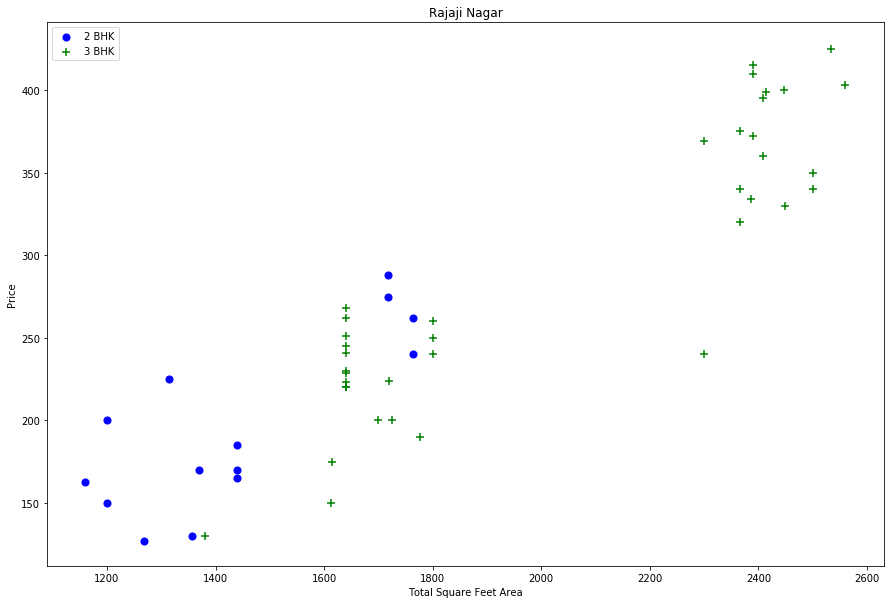

In [19]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(dffin,"Rajaji Nagar")

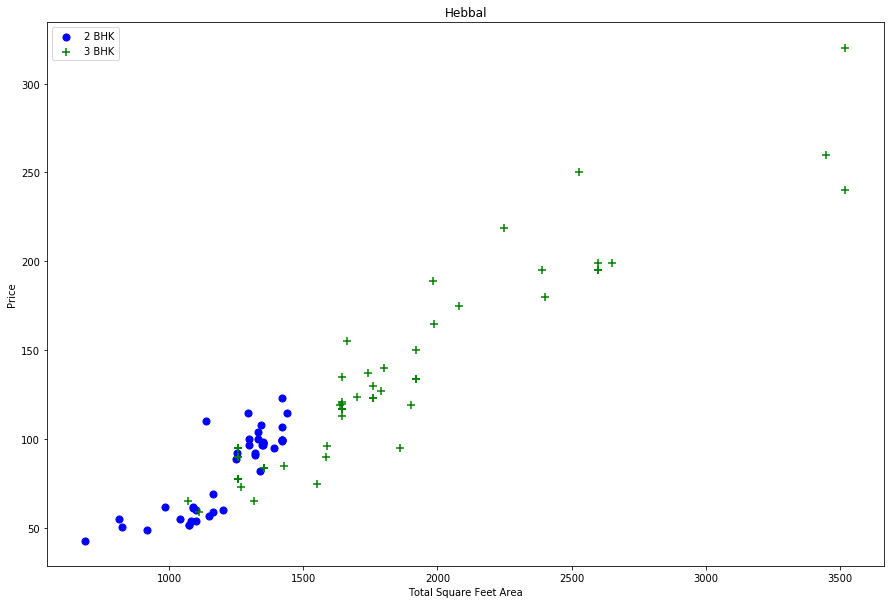

In [20]:
plot_scatter_chart(dffin,"Hebbal") # even more values where higher bhk has lesser price

##### We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk
##### we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [21]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
dffin2 = remove_bhk_outliers(dffin)

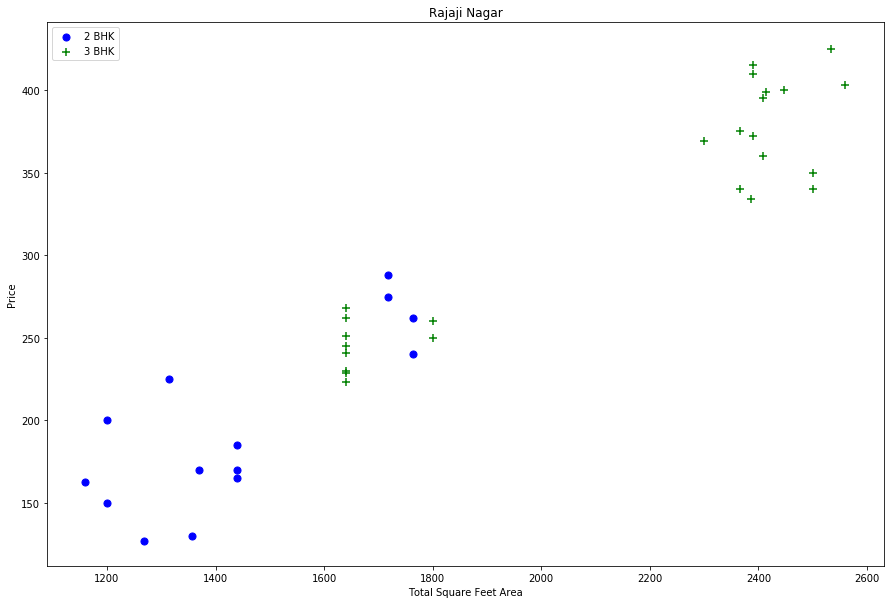

In [22]:
plot_scatter_chart(dffin2,"Rajaji Nagar") # values are removed

In [23]:
dffin2.shape

(7380, 6)

### Outlier Detection - column bhk wrt to bath and bhk

In [24]:
dffin2.bath.unique() # 16 baths!! 13 baths!! - definetly an outlier 

array([ 2.,  3.,  4.,  5.,  8.,  1.,  6., 14.,  7.,  9., 12., 16., 13.])

(array([4.807e+03, 1.768e+03, 6.820e+02, 8.100e+01, 2.900e+01, 7.000e+00,
        0.000e+00, 3.000e+00, 2.000e+00, 1.000e+00]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

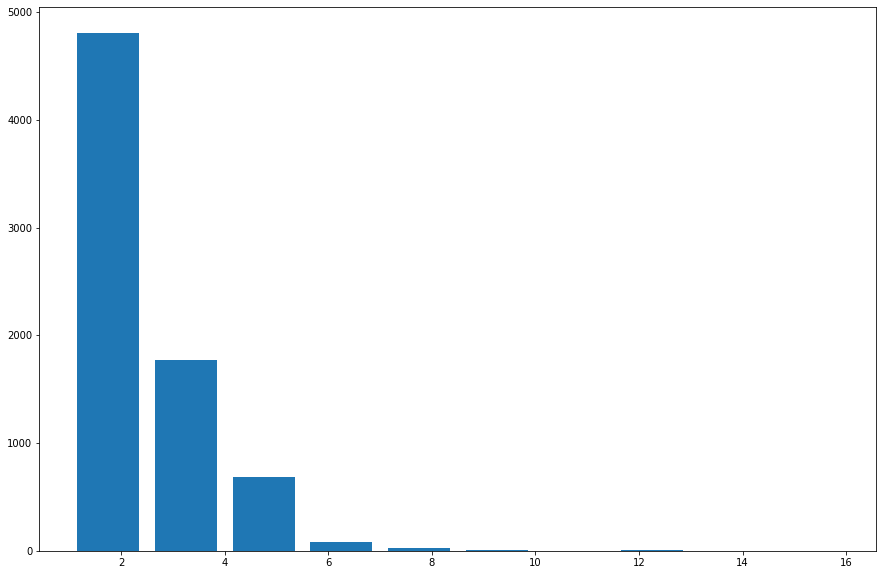

In [25]:
plt.hist(dffin2.bath,rwidth=0.8)

In [26]:
dffin2[dffin2.bath>10]

,location,total_sqft,bath,price,bhk,price_per_sqft
597,BTM 1st Stage,3300.000,14.000,500.000,9,15151.515
5338,Neeladri Nagar,4000.000,12.000,160.000,10,4000.000
8537,other,12000.000,12.000,525.000,10,4375.000
8623,other,10000.000,16.000,550.000,16,5500.000
9327,other,6000.000,12.000,150.000,11,2500.000
9643,other,5425.000,13.000,275.000,13,5069.124


In [27]:
dffin2[dffin2.bath>dffin2.bhk+2]

,location,total_sqft,bath,price,bhk,price_per_sqft
597,BTM 1st Stage,3300.000,14.000,500.000,9,15151.515
1653,Chikkabanavar,2460.000,7.000,80.000,4,3252.033
5299,Nagasandra,7000.000,8.000,450.000,4,6428.571
6776,Thanisandra,1806.000,6.000,116.000,3,6423.034
8465,other,11338.000,9.000,1000.000,6,8819.898


##### If you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [28]:
dffin3 = dffin2[dffin2.bath<dffin2.bhk+2]
dffin3.shape

(7302, 6)

# Model Build

In [29]:
df = dffin3
df.head(3)

,location,total_sqft,bath,price,bhk,price_per_sqft
1,Devarachikkanahalli,1250.000,2.000,40.000,2,3200.000
2,Devarachikkanahalli,1200.000,2.000,83.000,2,6916.667
3,Devarachikkanahalli,1170.000,2.000,40.000,2,3418.803


##### categorical feature location needs to be encoded

In [30]:
dummies = pd.get_dummies(df.location)
dummies

,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10217,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
df_new = pd.concat([df,dummies.drop('other',axis='columns')],axis='columns') # to avoid dummy variable trap we remove 'Other'
df_new.head(3)

,location,total_sqft,bath,price,bhk,price_per_sqft,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,Devarachikkanahalli,1250.000,2.000,40.000,2,3200.000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Devarachikkanahalli,1200.000,2.000,83.000,2,6916.667,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Devarachikkanahalli,1170.000,2.000,40.000,2,3418.803,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df_new.drop('location', axis='columns', inplace=True, errors='ignore')
df_new.head(3)

,total_sqft,bath,price,bhk,price_per_sqft,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.000,2.000,40.000,2,3200.000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.000,2.000,83.000,2,6916.667,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.000,2.000,40.000,2,3418.803,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_new.shape

(7302, 258)

In [34]:
X = df_new.drop(['price', 'price_per_sqft'], axis='columns', errors ='ignore')
y = df.price
y.head()

1   40.000
2   83.000
3   40.000
4   65.000
5   43.000
Name: price, dtype: float64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

In [36]:
X.head()

,total_sqft,bath,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.000,2.000,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.000,2.000,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.000,2.000,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.000,2.000,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,947.000,2.000,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8432266578791773

##### implementing k-fold cross val to improve the accuracy 

In [38]:
cv = KFold(n_splits=5, random_state=10, shuffle=True)
score = cross_val_score(lr, X, y, cv =cv)
score # score hasnt improved but is consistent, hence our model and data is consistent

array([0.84322666, 0.86909788, 0.86401504, 0.83904004, 0.81576648])

##### How about using different models as well, we can use gridsearchcv for that purpose!

In [39]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, random_state=10)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=True)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params':gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

grid_df = find_best_model_using_gridsearchcv(X,y) 

##### Build the DT classifier with the best parameters

In [40]:
grid_df # clearly linear reg is the best

,model,best_score,best_params
0,linear_regression,0.833,{'normalize': True}
1,lasso,0.684,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.756,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


##### hence built the LR model again with normalize = True parameter, results in slight increase in accuracy

In [41]:
lr_new = LinearRegression(normalize=True)
lr_new.fit(X_train, y_train)
lr_new.score(X_test, y_test)

0.8432266578791846

##### Predictions - the functions builds up a random x input to test on the model 

In [42]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0] # identify the location index, since now in X its one-hot encoded

    x = np.zeros(len(X.columns)) # first assign the input with all zeros
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index: # if the array has some value - in case of 'Others', it wont have any value
        loc_index = loc_index[0]
        x[loc_index] = 1 #set the specific location to 1, others are already 0
    return lr_new.predict([x])[0]

In [43]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

79.78026788530937

In [44]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

84.7022710563535

In [45]:
predict_price('Indira Nagar',1000, 1, 2)

179.60388194517964

In [46]:
predict_price('Indira Nagar',1000, 5, 5)

200.99727066066686

In [47]:
predict_price('other', 1000, 2, 2)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


81.12725152580917

### Export the tested model to a pickle file

In [52]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_new,f)

### Export location and column information to a json file that will be useful later on in our prediction web application


In [51]:
import json
columns = {'data_columns' : [col.lower() for col in X.columns]}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))